In [17]:
import svgwrite
from svgwrite import cm, mm, text  
from IPython.display import SVG, display, HTML
import numpy as np
import itertools
import random
#random.seed(0)
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
class RandomWalk():
    def __init__ (self, dwg, start, n, m, k, grid_size,
                  diag_kwargs, axes_kwargs, path_kwargs, perp_kwargs, circle_radius=2):
        self.heights = get_random_dyck_path(n, m, k)
        self.start = np.array(start)
        self.n = n
        self.m = m
        self.k = k
        self.grid_size = grid_size
        self.dwg = dwg
        self.circle_radius = circle_radius
        
        self.axes_kwargs = axes_kwargs
        self.diag_kwargs = diag_kwargs
        self.path_kwargs = path_kwargs
        self.perp_kwargs = perp_kwargs
        for kwargs in (self.axes_kwargs, self.diag_kwargs, self.path_kwargs, self.perp_kwargs):
            kwargs['stroke_width'] *= self.grid_size
        
    
    def add_line(self, start, end, line_kwargs, delta=None,
                 start_truncate=0, end_truncate=0, dasharray=False):
        delta = np.array([0.0, 0.0]) if delta is None else delta
        delta += self.start
        
        orientation = end - start
        length = np.linalg.norm(orientation)
        actual_start = start + start_truncate*orientation/length + delta
        actual_end = end - end_truncate*orientation/length + delta
        if dasharray:
            self.dwg.add(dwg.line(actual_start.tolist(), actual_end.tolist(), **line_kwargs).dasharray(dasharray))
        else:
            self.dwg.add(dwg.line(actual_start.tolist(), actual_end.tolist(), **line_kwargs))
            
    def draw_axes(self):
        current_position = np.copy(self.start)
        delta_x = np.array([self.grid_size, 0])
        delta_y = np.array([0, -self.grid_size])
        max_x = self.m
        max_y = self.n
        for x in range(max_x + 1):
            for y in range(max_y + 1):
                current_position = self.start + x * delta_x + y * delta_y
                self.dwg.add(dwg.circle(center=current_position.tolist(), r=0.3 * self.circle_radius,
                                        **self.axes_kwargs, fill=self.axes_kwargs['stroke']))
                
        for x in range(max_x):
            current_position = x * delta_x
            self.add_line(current_position, current_position + max_y * delta_y, line_kwargs=self.axes_kwargs)
        for y in range(1, max_y + 1):
            current_position = y * delta_y
            self.add_line(current_position, current_position + max_x * delta_x, line_kwargs=self.axes_kwargs)
        
    def draw_diagonals(self):
        origin = np.array([0, 0])
        right_endpoint = self.m * self.grid_size * np.array([1, 0])
        top_endpoint = right_endpoint - self.n * self.grid_size * np.array([0, 1])
        diagonal_endpoint = self.m * self.grid_size * np.array([1, -1])
        
        self.add_line(origin, right_endpoint, line_kwargs=self.diag_kwargs)
        self.add_line(right_endpoint, top_endpoint, line_kwargs=self.diag_kwargs)
            
        truncate_unit_length = self.grid_size / np.sqrt(2) 
        start_truncate_length = (self.k - 1) * truncate_unit_length
        end_truncate_length = (self.k - 1) * truncate_unit_length
        self.add_line(origin, diagonal_endpoint,
                      line_kwargs=self.diag_kwargs,
                      delta=self.grid_size * 0.5 * np.array([self.k-1, self.k-1]),
                      start_truncate=start_truncate_length, end_truncate=end_truncate_length,
                      dasharray=(self.grid_size/2, self.grid_size/4))
        
    def draw_path(self):
        circle_fill_color = [
            'white' if position[0]-position[1] < k-1 else self.path_kwargs['stroke']
            for position in self.heights
        ]
        flipped_coordinates = [np.multiply(np.array([1, -1]), position) for position in self.heights]
        dyck_coordinates = [self.grid_size * position for position in flipped_coordinates]
        orthogonal_direction = 0.5 * grid_size * np.array([1, 1])
        
        for start, end in zip(dyck_coordinates[:-1], dyck_coordinates[1:]):
            self.add_line(start, end, line_kwargs=self.path_kwargs)
            
        distance_to_diagonal = 0
        for i, (position, previous_position) in enumerate(zip(dyck_coordinates[1:], dyck_coordinates[:-1])):
            x_shift = (position - previous_position)[0]
            distance_to_diagonal += 1 if x_shift < 0.5 else -1
            distance_to_diagonal += 1 if i < self.k - 1 else 0
            distance_to_diagonal -= 1 if i > 2 * self.m - self.k else 0
            self.add_line(position, position + distance_to_diagonal * orthogonal_direction,
                          line_kwargs=self.perp_kwargs,
                          dasharray=(self.grid_size/4, self.grid_size/8))
            
        for position, fill_color in zip(dyck_coordinates, circle_fill_color):
            circle_position = self.start + position
            self.dwg.add(dwg.circle(center=circle_position.tolist(), r=self.circle_radius,
                                    **self.path_kwargs, fill=fill_color))
        
    def draw(self):
        self.draw_diagonals()
        self.draw_axes()
        self.draw_path()
        
        
def get_random_walk(n, m):
    delta_list = [np.array([1, 0]) for _ in range(m)] + [np.array([0, 1]) for _ in range(n)]
    random.shuffle(delta_list)
    return [np.array([0, 0])] + list(itertools.accumulate(delta_list)) 

def get_random_dyck_path(n, m, k=1):
    if m > n + k - 1:
        raise AssertionError(u'Invalid parameters')
    random_walk = get_random_walk(n, m)
    while max(map(lambda position: position[0]-position[1], random_walk)) > k-1:
        random_walk = get_random_walk(n, m)
    return random_walk

/home/shankhabiswas/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/shankhabiswas/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


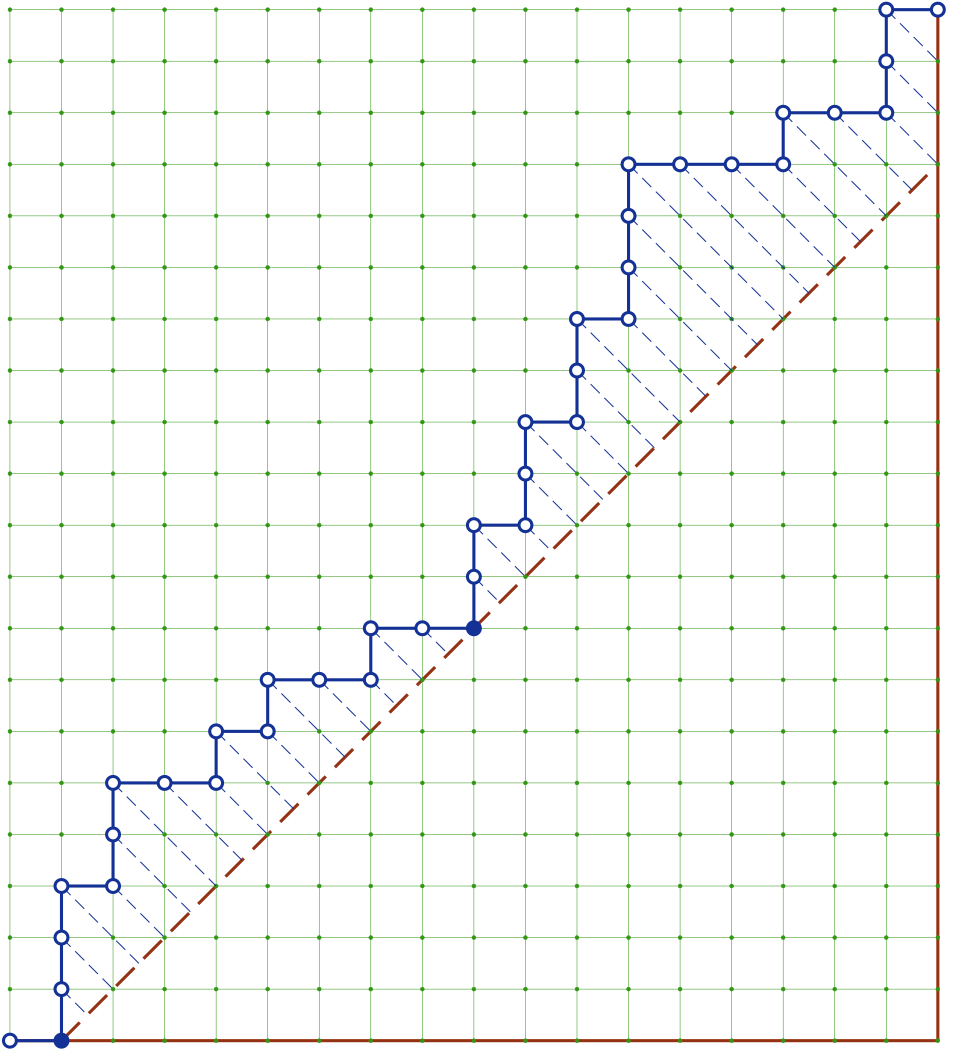

In [58]:
max_width = 980
margin_multiplier = 1.5

n = 20
m = 18
k = 2

grid_size = max_width / (m + 1)
circle_radius = grid_size / 8
figure_margin = margin_multiplier * circle_radius
shift_down = n * grid_size + figure_margin
rect_height = shift_down + 2 * figure_margin
dwg = svgwrite.Drawing(filename="dyck.svg", size=(max_width, rect_height))

diag_kwargs = {'stroke': svgwrite.rgb(150, 50, 20), 'stroke_width': .06}
axes_kwargs = {'stroke': svgwrite.rgb(50, 150, 20), 'stroke_width': .01}
path_kwargs = {'stroke': svgwrite.rgb(20, 50, 150), 'stroke_width': .06}
perp_kwargs = {'stroke': svgwrite.rgb(20, 50, 150), 'stroke_width': .02}
            
dyck_path = RandomWalk(dwg, (margin_multiplier * circle_radius, shift_down), n, m,
                       k=k, grid_size=grid_size, circle_radius=circle_radius,
                       diag_kwargs=diag_kwargs, axes_kwargs=axes_kwargs,
                       path_kwargs=path_kwargs, perp_kwargs=perp_kwargs)
dyck_path.draw()
SVG(dwg.tostring())

In [59]:
dwg.save()